In [4]:
import db
import logic
import matplotlib.pyplot as plt
import pandas as pd
import nltk
%matplotlib nbagg

# Drugs and Fake IDs: Data Mining The Dark Web
<hr>

This Jupyter Notebook belongs to a data mining project takign place at UEL. The aim of this research is to monitor a selection of dark web resources to gain insights regarding the type of products and services that are sold, and to possibly identify any significant trends.

On the summer of 2015, a web crawling script was run over a dark web hosted e-commerce platform, collecting records of products being sold on the site. The purpose of this notebook is to analyse the data collected.
## 1. Introduction
 
### Database schema:
Figures below describe the schema of the given database

In [2]:
db.pandas_query('SHOW tables;')

,Tables_in_dark_web
0,tblCategory
1,tblProduct
2,tblSubCategory
3,tblVendor
4,tblWebsite


<hr />
##### Data definition can be obtained by the following query. Replace the table name for any of the above

In [3]:
db.pandas_query('DESCRIBE tblProduct;')

,Field,Type,Null,Key,Default,Extra
0,product_id,int(20),NO,PRI,None,auto_increment
1,product_model,varchar(200),NO,UNI,None,
2,product_name,varchar(100),NO,,None,
3,product_description,text,NO,,None,
4,product_origin,varchar(50),NO,,None,
5,product_postage,varchar(50),NO,,None,
6,product_price,varchar(50),NO,,None,
7,vendor_id,int(10),NO,MUL,None,
8,subCategory_id,int(10),NO,MUL,None,
9,time_stamp,date,NO,,None,


## 2. Market Activity Analysis

Perhaps the first thing that comes to mind when analysing a market place is to measure its size in terms of units traded,
product taxonomy, trade value, overall value etc.

These data set has been collected during the following date range:


In [85]:
db.pandas_query('''
    SELECT min(time_stamp) as 'Start Date', max(time_stamp) as 'End Date' FROM tblProduct;
    ''')

,Start Date,End Date
0,2015-07-22,2015-09-03


Within this time, the following number of records have been collected:

In [87]:
db.pandas_query('''
    SELECT count(*) as 'Total Product Records' FROM tblProduct;
    ''')

,Total Product Records
0,30680


<hr>



### 2.1 Product Categories

The site divides the product listing into a number of categories and subcategories. We will now have a look at those categories and see which products are the most popular in this particular site.

<IPython.core.display.Javascript object>


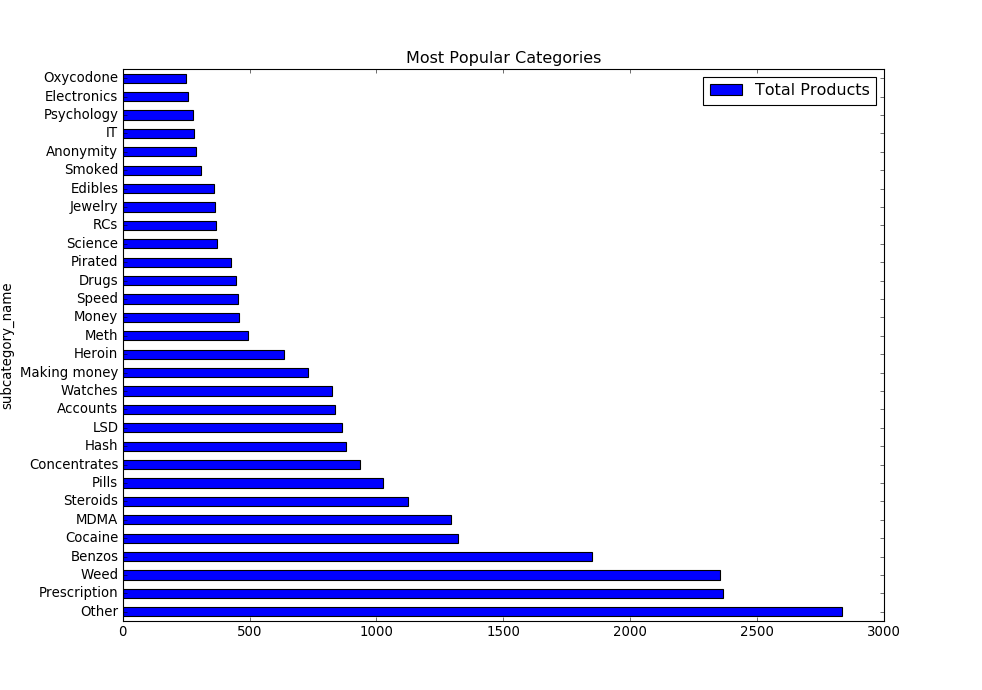

In [10]:

dataframe = db.pandas_query('''
        SELECT B.subcategory_name, count(A.product_name) as 'Total Products' 
        FROM tblProduct A
        LEFT JOIN tblSubCategory B
            ON A.subCategory_id = B.subCategory_id
        GROUP BY B.subcategory_name
        ORDER BY -count(A.product_name)
        limit 30;
        ''',
        index_col='subcategory_name')
dataframe.plot(kind='barh', title='Most Popular Categories')



From the above query we find that 20 out the 30 most common subcategories are drug related. The other main area of research we are interested on is the illegal market of passports and ids. While there seems not to be any trace of those sub categories, we yet have to analyse the "Other" subcategory.

Let's find out what percentage of these listings do actually fall in the drugs category.


   drug_listings  other
0          20849   4440


<IPython.core.display.Javascript object>


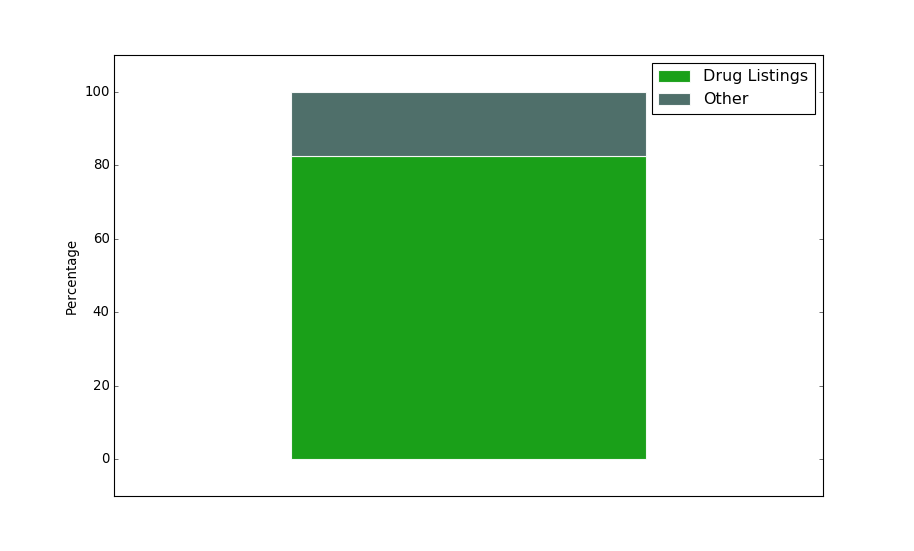

In [11]:


comparison_df = db.pandas_query('''
    SELECT count(*) as 'drug_listings' FROM tblProduct
    WHERE subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        ); 
    ''')

comparison_df['other'] = dataframe.sum()[0] - comparison_df.iloc[0][0]
print (comparison_df)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(comparison_df['drug_listings']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total
totals = [i+j for i,j in zip(comparison_df['drug_listings'], comparison_df['other'])]

# Create the percentage
pre_rel = [i / j * 100 for  i,j in zip(comparison_df['drug_listings'], totals)]
mid_rel = [i / j * 100 for  i,j in zip(comparison_df['other'], totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       pre_rel, 
       label='Drug Listings', 
       alpha=0.9, 
       color='#019600',
       width=bar_width,
       edgecolor='white'
       )
ax.bar(bar_l, 
       mid_rel, 
       bottom=pre_rel,  
       label='Other', 
       alpha=0.9, 
       color='#3C5F5A', 
       width=bar_width,
       edgecolor='white'
       )



# Set the ticks to be first names
ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.get_xaxis().set_ticks([])
ax.legend()

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# shot plot
plt.show()



## 2.2 Geografical Activity Distribution

### 2.2.1 Total Products listed by country of origin
  



<IPython.core.display.Javascript object>


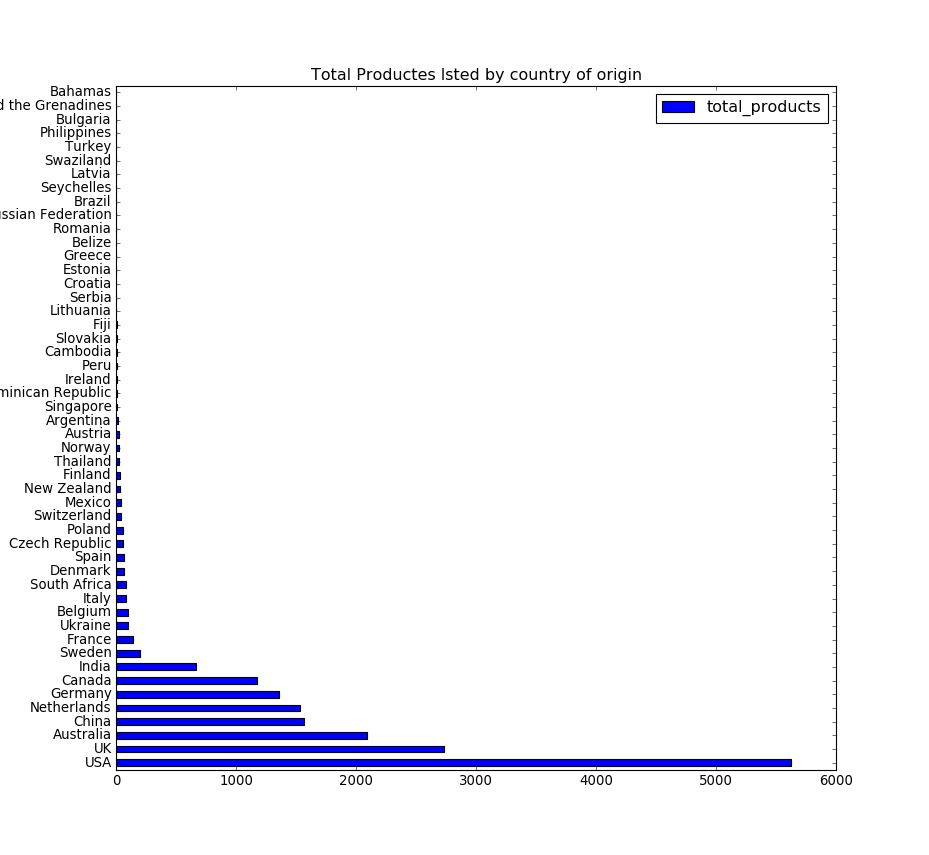

In [8]:
countries_df = db.pandas_query('''
    SELECT count(*) as 'total_products', product_origin FROM tblProduct
    WHERE product_origin != ''
    GROUP BY product_origin
    ORDER BY total_products DESC;
    ''', index_col='product_origin')

countries_df.plot(kind='barh', title='Total Productes lsted by country of origin')

### 2.2.2 Total drug listings by product country of origin.


<IPython.core.display.Javascript object>


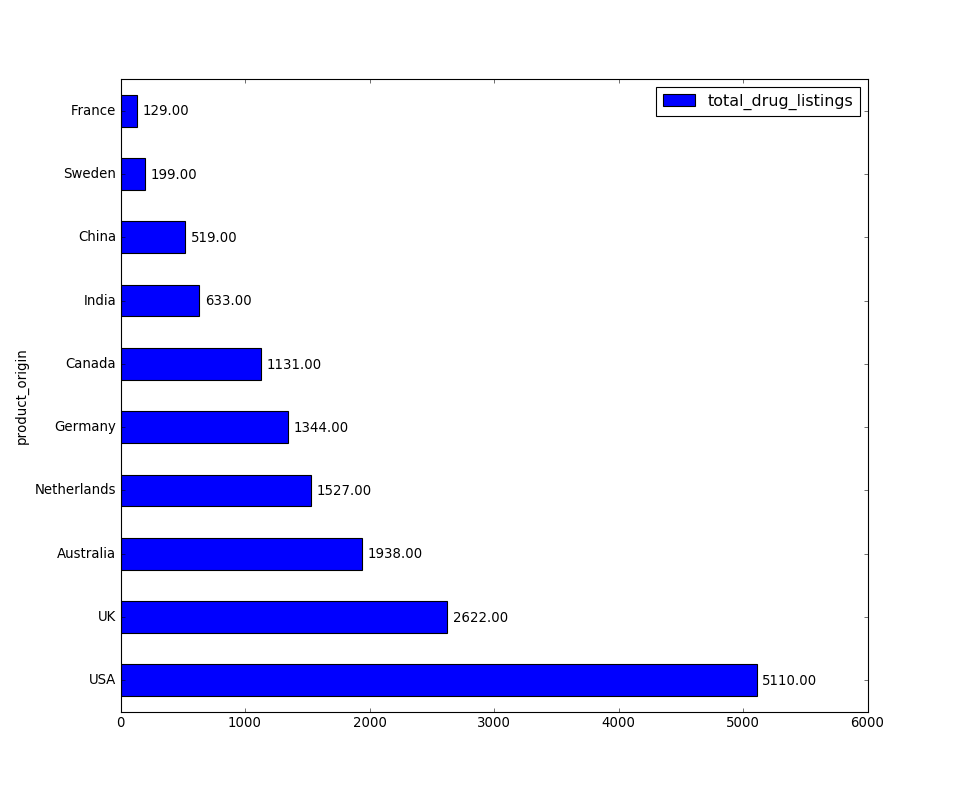

In [6]:
countries_df = db.pandas_query('''
    SELECT count(*) as 'total_drug_listings', product_origin FROM tblProduct
    WHERE product_origin != ''
    and subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        )
    GROUP BY product_origin
    ORDER BY total_drug_listings DESC
    LIMIT 10;
    ''', index_col='product_origin')

countries_ax = countries_df.plot(kind='barh')
for p in countries_ax.patches:
    countries_ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), 
        p.get_y()), xytext=(5, 10), textcoords='offset points')

### HIGHLIGHTS:
 - USA has the leading position in total products sold as well as in the drugs market
 - For Most countries, drugs are by far the most common type of product
 - Interestingly, in the case of <b>China</b>, only 24% of their listed products belong to drug related subcategories
 
Given the chinese scenario, lets dive a little bit deeper and see what kind of products are attracting more attention in the Chinese Market.

<IPython.core.display.Javascript object>


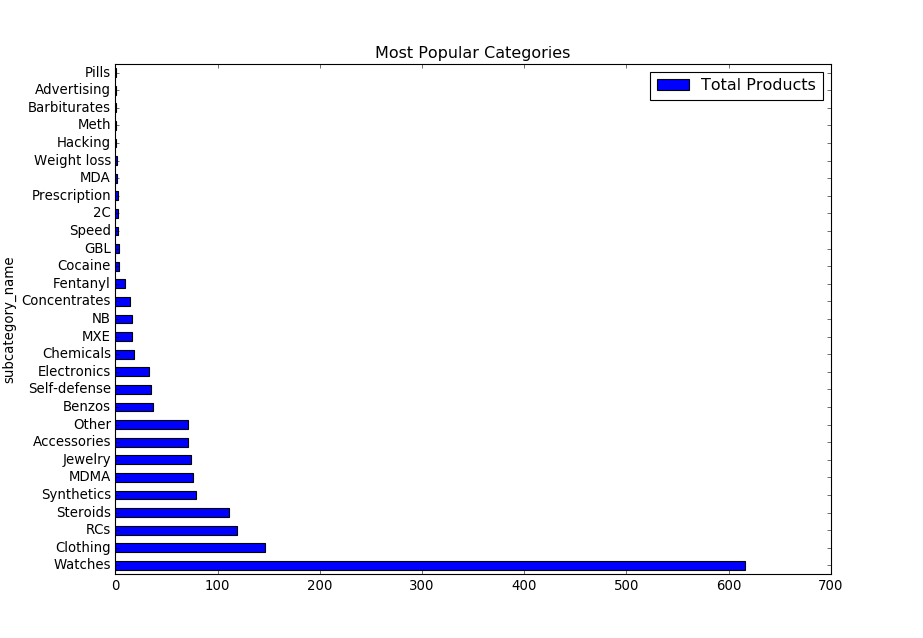

In [12]:
china_df = db.pandas_query('''
    SELECT B.subcategory_name, count(A.product_name) as 'Total Products' 
    FROM tblProduct A
    LEFT JOIN tblSubCategory B
        ON A.subCategory_id = B.subCategory_id
    WHERE product_origin = 'China'
    GROUP BY B.subcategory_name
    ORDER BY -count(A.product_name)
    limit 30;
    ''',
    index_col='subcategory_name')
china_df.plot(kind='barh', title='Most Popular Categories')

### 2.2.3 Main Drug Providers

As we have previously seen, we know that some of the most popular drugs on offer in this market place are Cocaine, weed, MDMA, LSD or Heroin. We will try to find the top three providing countries for each of these drugs

<IPython.core.display.Javascript object>


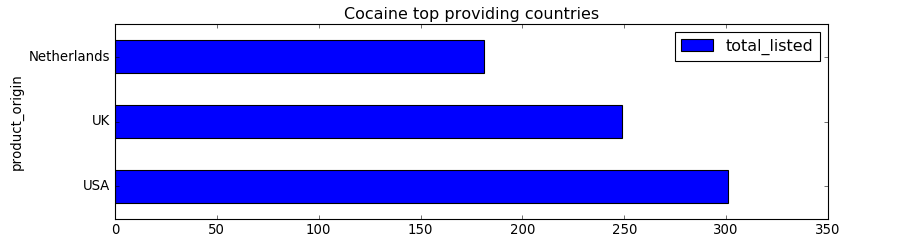

<IPython.core.display.Javascript object>


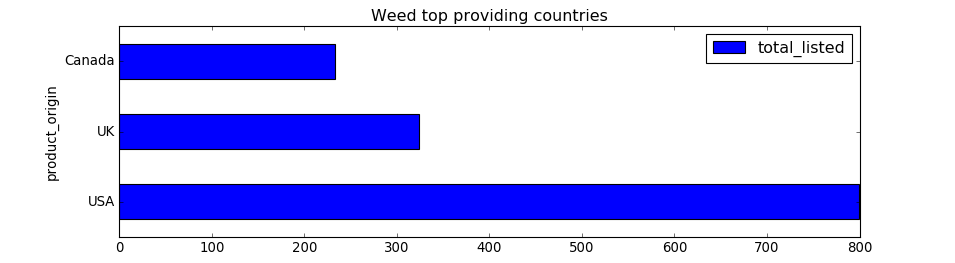

<IPython.core.display.Javascript object>


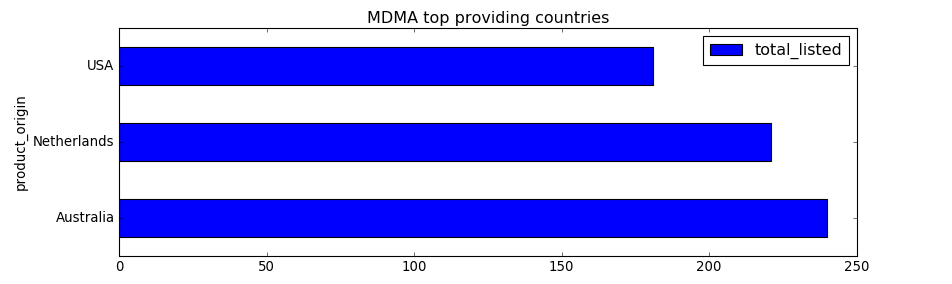

<IPython.core.display.Javascript object>


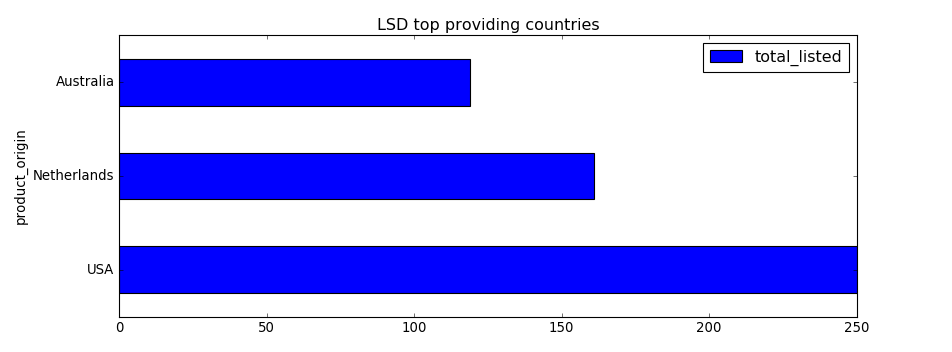

<IPython.core.display.Javascript object>


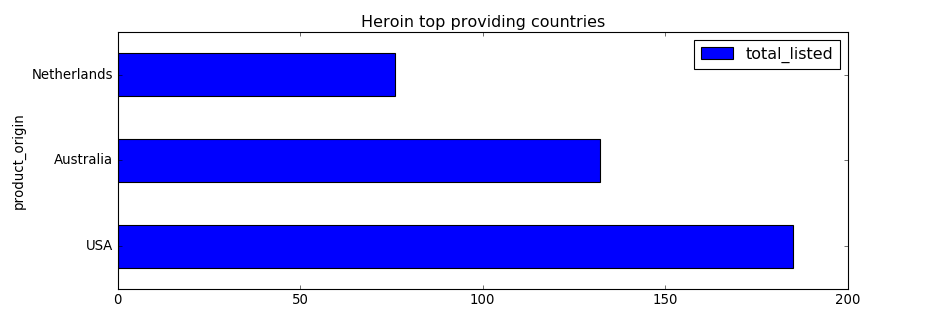

<IPython.core.display.Javascript object>


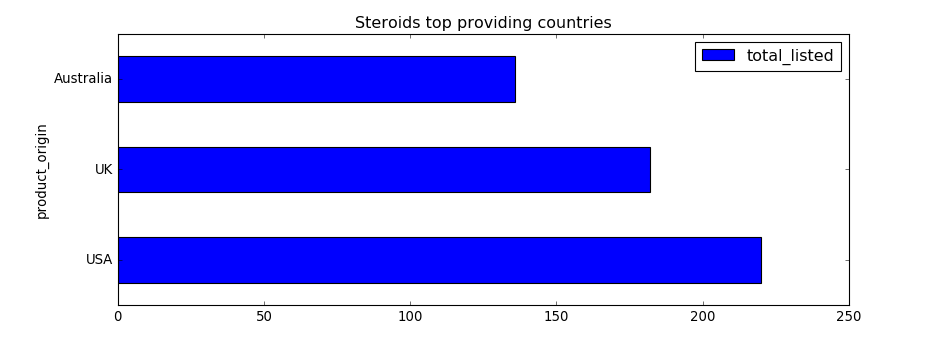

<IPython.core.display.Javascript object>


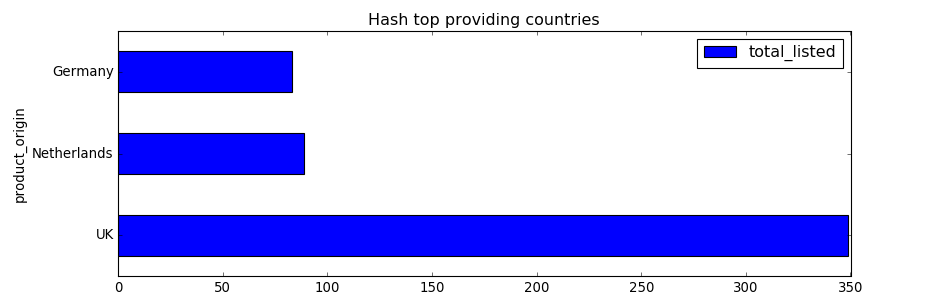

In [23]:
base_drugs_query = '''
    SELECT count(*) as 'total_listed', product_origin FROM tblProduct
    WHERE subCategory_id in (SELECT subCategory_id FROM tblSubCategory
        WHERE subCategory_name = '{}')
    AND product_origin != ''
    GROUP BY product_origin
    ORDER BY total_listed DESC
    LIMIT 3;
    '''
drugs_list = ['Cocaine', 'Weed', 'MDMA', 'LSD', 'Heroin', 'Steroids', 'Hash']
drug_data = {}
ax = None
for drug in drugs_list:
    df = db.pandas_query(base_drugs_query.format(drug), index_col='product_origin')
    df.plot.barh(title='{} top providing countries'.format(drug))


## 2.3 Time series Analysis


This section will try to understand the evolution over time of Agora's supply to find out growth rates in terms of total offerings as well as in the specifics of drugs.

 ### 2.3.1 Day-on-day supply analysis
 
 

<IPython.core.display.Javascript object>


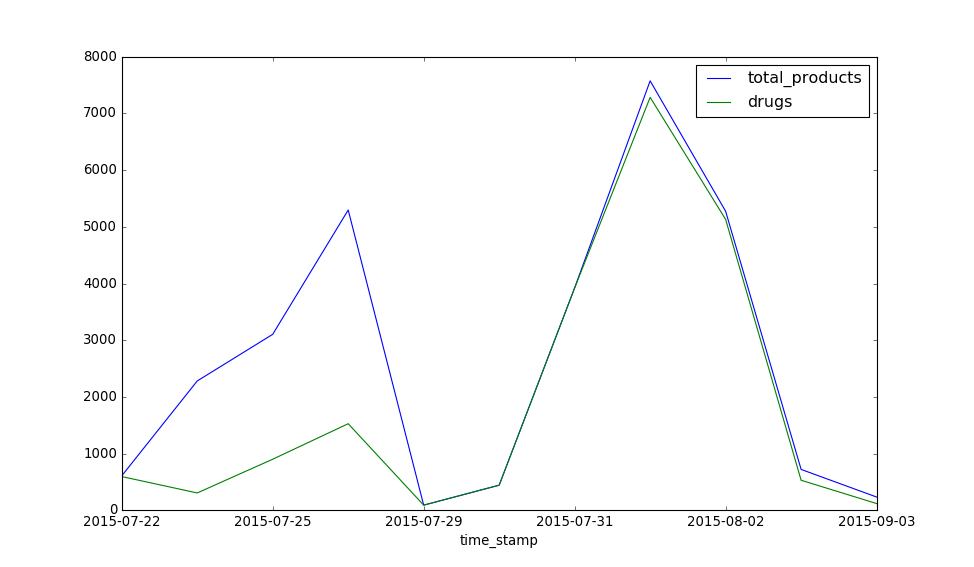

In [51]:
dayonday_df = db.pandas_query('''
    SELECT count(*) as total_products, time_stamp FROM tblProduct
    GROUP BY time_stamp;
    ''', index_col='time_stamp')
dayonday_drugs_df = db.pandas_query('''
    SELECT count(*) as drugs, time_stamp FROM tblProduct
    WHERE subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        )
    GROUP BY time_stamp;
    ''', index_col='time_stamp')
dayonday_df2 = pd.concat([dayonday_df, dayonday_drugs_df], axis='time_stamp', join='inner')
dayonday_df2.plot()

<hr>
Unfortunately, we can't analyse this market growth over time, as there are not enough data points. The growth of the drugs market share over time seems to be also unbearable for the same reason.

# 3. Market quantitative analysis

The currency used in this dark web hosted commerce platform is the Bitcoin. The dataset does contain the bitcoin price at which each listing has been placed, however, Bitcoin exchange rates are very volatile. Therefore, it would be meaningless to analyse the dataset in terms of its bitcoin value. Instead, each of the Bitcoin values have been converted to both GBP and USD as of the market exchange rate as of the day the product was listed on the website.



### 3.1 Natural Language processing: Data Mining Listing quantities and measurement units
Our listings product quantites are not suitable for data analysis, as they are cotained within title and description fields which are just composed of unstructured text blocks.
In order to extract those quantities we can either manipulate the string fields with regular expressions or use Natural Language proccessing to extract the required values using semantic and grammar machine learning algorithms.
There is a powerfull NLP library called NLTK that we will use in our attempt to extract those values.
Let's look at the folliwng two title examples extracted from the 'Cocaine' subcategory dataset:
<blockquote>"6 Grams Pure Cocaine (SAFE,ZERO CUTS & PURE+FREE COKE DAILY)"</blockquote>
<blockquote>"SALE!! 28G Cocaine - 92% Purity -Platinum Quality - No Cuts FE LISTING"</blockquote>
We start by tokenizing the sentence into words and analyze the word types grammatically

In [2]:
string = "6 Grams Pure Cocaine (SAFE,ZERO CUTS & PURE+FREE COKE DAILY)"
tokenized = nltk.word_tokenize(string)
tagged = nltk.pos_tag(tokenized)
print (tagged)


[('6', 'CD'), ('Grams', 'NNP'), ('Pure', 'NNP'), ('Cocaine', 'NNP'), ('(', '('), ('SAFE', 'NNP'), (',', ','), ('ZERO', 'NNP'), ('CUTS', 'NNP'), ('&', 'CC'), ('PURE+FREE', 'NNP'), ('COKE', 'NNP'), ('DAILY', 'NNP'), (')', ')')]


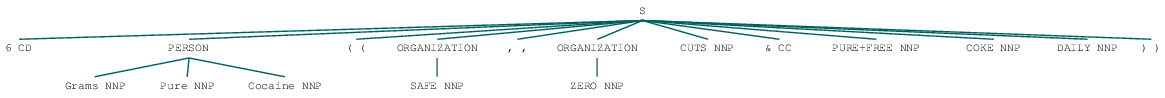

In [3]:
named_entities = nltk.ne_chunk(tagged)
named_entities


As expected, the unsupervised learning algorithm wasn't very accurate and has classified the words 'Grams Pure Cocaine' as a persons name, given that is composed of 3 capitalized words.

<p> Let's now move into the second example. </p>


In [2]:
string = "SALE!! 28G Cocaine - 92% Purity -Platinum Quality - No Cuts FE LISTING"
tokenized = nltk.word_tokenize(string)
tagged2 = nltk.pos_tag(tokenized)
tagged2

NameError: name 'nltk' is not defined

In this particular case our grammar learning has diverted from the previous example as the word tokenizing algorithm has returned the word 28G rather than "28" and "G" as separate words. As the problem has happened at the word tokenization process, let's add a regular expression check to make sure CD and unit are returned separately:

In [3]:
tokenizer_regex = r'(?u)\d+(?:\.\,\d+)?|\w+|%'
tokenized = nltk.regexp_tokenize(string, tokenizer_regex)
tagged3 = nltk.pos_tag(tokenized)
tagged3

NameError: name 'nltk' is not defined


The regular expression based tokenizer has worked better, as it does now effectively split the unit from it's numerical value. The unit though is being classified as a proper noun (NNP) instead of a nount (NN) as the word is capitalized.
Finally, we can "chunk" the POS tags using a POS regex match to get those pairs

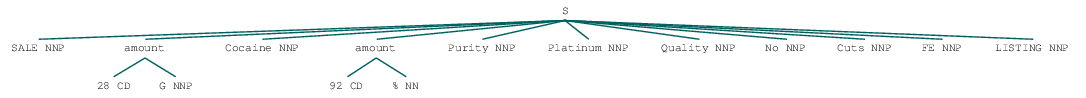

In [7]:
chunk_exp = r'''amount: {<CD><NN|NNP|NNS|NNPS>}'''
chunk_parser = nltk.RegexpParser(chunk_exp)
chunked = chunk_parser.parse(tagged3)
chunked

In [ ]:
chunked.draw()

### 3.1.1 Applying NLP to obtain Cocaine prices per gram

We want now to tune and refine the algorithm to fit our dataset. This code must be available to be used whenever we need to data mine values with a similar structure to the cocaine subset.

The following pair of functions will work as generators that an be applied to a series object:

In [ ]:
def amount_series_generator(chunk, unit):
    """
    function that yields measurment units from a given chunk
    """
    valid_units = logic.VALID_UNITS.get(unit)
    for subtree in chunk.subtrees(filter=lambda t: t.label() == 'amount'):
        leaves = subtree.leaves()
        if leaves[1][0].lower() in valid_units:
            return float(leaves[0][0])
    return None

def unit_series_generator(chunk, unit):
    """
    function that yields measurement units from a given chunk
    """
    valid_units = logic.VALID_UNITS.get(unit)
    for subtree in chunk.subtrees(filter=lambda t: t.label() == 'amount'):
        leaves = subtree.leaves()
        if leaves[1][0].lower() in valid_units:
            return unit
    return None


<p> The data we want to extract is contained within the product_name field. Then, we need to process the query and then apply the previously described algorithms subsequently </p>

In [11]:

tokenizer_regex = r'(?u)\d+(?:\.\,\d+)?|\w+|%'
chunk_exp = r'''amount: {<CD><NN|NNP|NNS|NNPS|JJ>}'''
chunk_parser = nltk.RegexpParser(chunk_exp)
cocaine_listings = db.get_drug_products('Cocaine')
cocaine_listings_names = cocaine_listings['product_name']
cocaine_words = cocaine_listings_names.apply(nltk.regexp_tokenize, args=(tokenizer_regex,))
cocaine_tagged = cocaine_words.apply(nltk.pos_tag)
cocaine_chunked = cocaine_tagged.apply(chunk_parser.parse)

cocaine_quants = cocaine_chunked.apply(amount_series_generator, args='g')
cocaine_units = cocaine_chunked.apply(unit_series_generator, args='g')
cocaine_listings['cocaine_quants'] = cocaine_quants
cocaine_listings['cocaine_units'] = cocaine_units
cocaine_listings[['product_id', 'product_name', 'cocaine_quants', 'cocaine_units']]





,product_id,product_name,cocaine_quants,cocaine_units
0,26563,Lidocaine HCL Numbing Powder - 10 Grams,10,g
1,26564,5 gram Pure Flakes free shipping,5,g
2,26565,1G Cocaine - 70% Purity - Silver Quality - ESCROW,1,g
3,26566,5g HIGH HEAT COCAINE,5,g
4,26567,Synthetic Cocaine 10g,10,g
5,26568,28 Grams of UKWHITE&#39;S Sociable Cocaine [FL...,28,g
6,26569,FE - High Quality Cocaine 0.5 Grams,5,g
7,26570,3.5g Cocaine **PROMOTION**,5,g
8,26571,9 gram Pure free shipping,9,g
9,26572,Ching 1g Free Shipping! Buy 3 get 1 Free!,1,g


The overview shows that the algorithms have performed as epected, but we still see some empty values still, mainly due to the lack of information on the product name.

In order to understand the success rate of the algorithms we can do:

In [17]:
failed = cocaine_units.isnull().sum()
print ('{} out of {} units obtained obtained'.format(len(cocaine_units) - failed, len(cocaine_units)))
print ('{}% success rate'.format(100-(failed/len(cocaine_units)*100)))

1174 out of 1323 units obtained obtained
88.73771730914588% success rate
